<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-span-of-time-in-years-does-the-data-cover?" data-toc-modified-id="What-span-of-time-in-years-does-the-data-cover?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What span of time in years does the data cover?</a></span></li><li><span><a href="#Scan-variables-for-missing-values" data-toc-modified-id="Scan-variables-for-missing-values-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scan variables for missing values</a></span></li><li><span><a href="#Visualise-earthquakes-by-year" data-toc-modified-id="Visualise-earthquakes-by-year-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualise earthquakes by year</a></span></li><li><span><a href="#Visualise-earthquake-frequency-and-mortality-by-year-and-region-code" data-toc-modified-id="Visualise-earthquake-frequency-and-mortality-by-year-and-region-code-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualise earthquake frequency and mortality by year and region code</a></span></li><li><span><a href="#Visualise-earthquake-frequency-and-mortality-by-year-and-continent" data-toc-modified-id="Visualise-earthquake-frequency-and-mortality-by-year-and-continent-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualise earthquake frequency and mortality by year and continent</a></span></li><li><span><a href="#Visualise-deaths-by-earthquake-intensity" data-toc-modified-id="Visualise-deaths-by-earthquake-intensity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualise deaths by earthquake intensity</a></span></li><li><span><a href="#Visualise-earthquakes-by-location" data-toc-modified-id="Visualise-earthquakes-by-location-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualise earthquakes by location</a></span></li><li><span><a href="#Visualise-earthquake-frequency-with-maps" data-toc-modified-id="Visualise-earthquake-frequency-with-maps-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualise earthquake frequency with maps</a></span></li><li><span><a href="#Animate-earthquake-locations-over-time" data-toc-modified-id="Animate-earthquake-locations-over-time-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Animate earthquake locations over time</a></span></li></ul></div>

In [1]:
# Import Necessary Libraries

from google.cloud import bigquery
from google.cloud.bigquery import Dataset
from google.cloud import storage

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [2]:
# function to print a table schema:
def printTableSchema(aTable):
    schemas = list(aTable.schema)
    if schemas:
        print('Table schema for {}:'.format(aTable.table_id))
        for aSchema in schemas:
            print('\t{0} {1}'.format(aSchema.name, aSchema.field_type))
        found = True
    else:
        found = False
    return found

# Set up BigQuery 

In [3]:
# Project created as a owner
private_project = 'magnetic-math-233501'

# Public project of big query
public_project = 'bigquery-public-data'

# Set storage client
storage_client = storage.Client()

# Set big query client
client = bigquery.Client(project=public_project)

In [4]:
dataset_id = 'noaa_significant_earthquakes'

# Get the public dataset
dataset_ref = client.dataset(dataset_id, project=public_project)

In [5]:
# Set the project as private to run queries
client = bigquery.Client(project=private_project)

In [6]:
table_ref = dataset_ref.table('earthquakes')
table = client.get_table(table_ref)
printTableSchema(table)

Table schema for earthquakes:
	id INTEGER
	flag_tsunami STRING
	year INTEGER
	month INTEGER
	day INTEGER
	hour INTEGER
	minute INTEGER
	second FLOAT
	focal_depth INTEGER
	eq_primary FLOAT
	eq_mag_mw FLOAT
	eq_mag_ms FLOAT
	eq_mag_mb FLOAT
	eq_mag_ml FLOAT
	eq_mag_mfa FLOAT
	eq_mag_unk FLOAT
	intensity INTEGER
	country STRING
	state STRING
	location_name STRING
	latitude FLOAT
	longitude FLOAT
	region_code INTEGER
	deaths INTEGER
	deaths_description INTEGER
	missing INTEGER
	missing_description INTEGER
	injuries INTEGER
	injuries_description INTEGER
	damage_millions_dollars FLOAT
	damage_description INTEGER
	houses_destroyed INTEGER
	houses_destroyed_description INTEGER
	houses_damaged INTEGER
	houses_damaged_description INTEGER
	total_deaths INTEGER
	total_deaths_description INTEGER
	total_missing INTEGER
	total_missing_description INTEGER
	total_injuries INTEGER
	total_injuries_description INTEGER
	total_damage_millions_dollars FLOAT
	total_damage_description INTEGER
	total_houses_des

True

## What span of time in years does the data cover?

In [7]:
query = """
        SELECT MAX(year), MIN(year)
        FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE year > 0
        
        """

earthquakes_stats = client.query(query).to_dataframe()

earthquakes_stats

,f0_,f1_
0,2019,10


In [8]:
query = """
        SELECT *
        FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE year = 10
        LIMIT 2
        
        """

client.query(query).to_dataframe()

,id,flag_tsunami,year,month,day,hour,minute,second,focal_depth,eq_primary,...,total_missing,total_missing_description,total_injuries,total_injuries_description,total_damage_millions_dollars,total_damage_description,total_houses_destroyed,total_houses_destroyed_description,total_houses_damaged,total_houses_damaged_description
0,38,None,10,None,None,None,None,None,18,7.1,...,None,None,None,None,None,None,None,None,None,None


Years covered in the database that are > 0 span from 10 to 2019. If we assume that the year is correct, a record from 10 compared to a record from 2019 probably won't have the same amount of information or accuracy (how were earthquakes measured in the year 10?), so let's limit our counting from 1900. 

In [9]:
query = """
        SELECT year, COUNT(*) AS num_earthquakes
        FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE year >= 1900
        GROUP BY year
        ORDER BY year
        """

earthquakes_by_year = client.query(query).to_dataframe()
earthquakes_by_year.head()

,year,num_earthquakes
0,1900,18
1,1901,18
2,1902,22
3,1903,22
4,1904,18


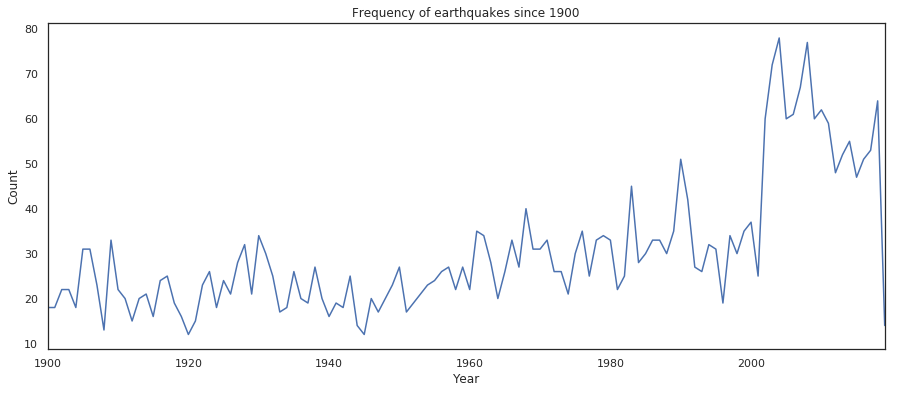

In [10]:
# Plot frequency of earthquakes by year

earthquakes_by_year.set_index('year').plot(kind='line', figsize=(15, 6), legend=None)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Frequency of earthquakes since 1900")
plt.show()

There seems to be a large increase in the number of earthquakes from the year 2000. This may be due to better data collection from this date. 

In [11]:
query = """
        SELECT COUNT(*)
        FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE year >= 2000
        """

client.query(query).to_dataframe()

,f0_
0,1102


In [12]:
query = """
        SELECT COUNT(*)
        FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE year < 2000 AND year >= 1980
        """

client.query(query).to_dataframe()

,f0_
0,641


The period from 2000-2019 has 11102 earthquakes recorded, which is almost twice the number of earthquakes from 1980-2000.

In [130]:
query = """
        SELECT country, latitude, longitude, year, total_deaths, total_missing, total_injuries, intensity
        FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE year >= 1900
        """

earthquakes_since_1900 = client.query(query).to_dataframe()

In [13]:
query = """
        SELECT *
        FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE year >= 2000
        """

earthquakes_since_2000 = client.query(query).to_dataframe()

In [14]:
earthquakes_since_2000.to_csv("../../data/earthquakes_since_2000.csv", index=False)

# EDA

## Scan variables for missing values

In [15]:
# Load in earthquakes dataframe

earthquakes_since_2000 = pd.read_csv("../../data/earthquakes_since_2000.csv")

In [16]:
# Check earthquakes dataframe

earthquakes_since_2000.head()

,id,flag_tsunami,year,month,day,hour,minute,second,focal_depth,eq_primary,...,total_missing,total_missing_description,total_injuries,total_injuries_description,total_damage_millions_dollars,total_damage_description,total_houses_destroyed,total_houses_destroyed_description,total_houses_damaged,total_houses_damaged_description
0,5735,Tsu,2003,11,17,6.0,43.0,6.8,33.0,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6738,Tsu,2005,6,15,2.0,50.0,53.1,10.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7532,Tsu,2007,8,2,3.0,21.0,42.8,21.0,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7601,NaN,2007,8,6,8.0,48.0,40.0,2.0,4.2,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7614,NaN,2007,8,17,0.0,38.0,56.0,0.0,1.6,...,NaN,NaN,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# View earthquake dataframe column types

earthquakes_since_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 47 columns):
id                                    1102 non-null int64
flag_tsunami                          197 non-null object
year                                  1102 non-null int64
month                                 1102 non-null int64
day                                   1102 non-null int64
hour                                  1100 non-null float64
minute                                1100 non-null float64
second                                1080 non-null float64
focal_depth                           1093 non-null float64
eq_primary                            1101 non-null float64
eq_mag_mw                             857 non-null float64
eq_mag_ms                             528 non-null float64
eq_mag_mb                             815 non-null float64
eq_mag_ml                             108 non-null float64
eq_mag_mfa                            0 non-null float64
eq_mag_unk

In [18]:
# Check dataframe dimensions

earthquakes_since_2000.shape

(1102, 47)

In [19]:
# Count NaN values for each column

earthquakes_since_2000.isnull().sum()

id                                       0
flag_tsunami                           905
year                                     0
month                                    0
day                                      0
hour                                     2
minute                                   2
second                                  22
focal_depth                              9
eq_primary                               1
eq_mag_mw                              245
eq_mag_ms                              574
eq_mag_mb                              287
eq_mag_ml                              994
eq_mag_mfa                            1102
eq_mag_unk                            1098
intensity                              881
country                                  0
state                                 1048
location_name                            0
latitude                                 0
longitude                                0
region_code                              0
deaths     

In [20]:
# Does each row have at least one measurement?

measures = ['focal_depth', 'eq_primary', 'eq_mag_mw', 'eq_mag_ms', 
            'eq_mag_mb', 'eq_mag_ml', 'eq_mag_mfa', 'eq_mag_unk', 'intensity']

eq_measurements = earthquakes_since_2000[measures]

# There are 9 measurements. Are there any rows in eq_measurements that have 9 NaNs?

(eq_measurements.isnull().sum(axis=1) == len(measures)).sum()

0

Every record since 2000 has at least one measure of activity recorded. 

## Visualise earthquakes by year

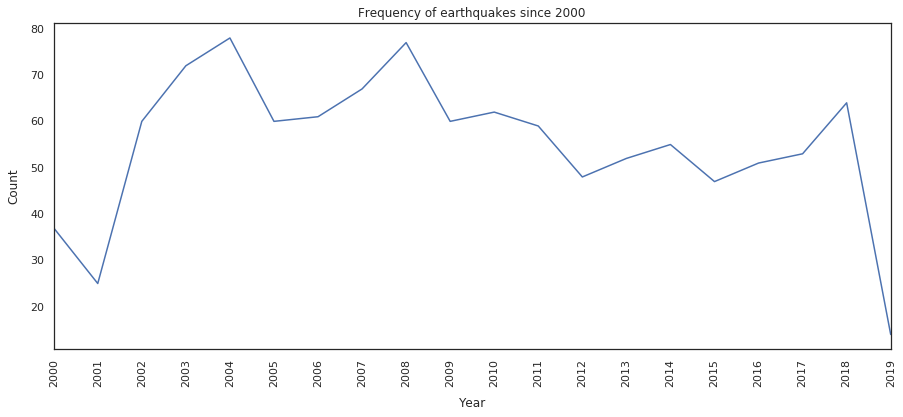

In [21]:
eq_freq_year = earthquakes_since_2000['year'].value_counts().sort_index()

ax = eq_freq_year.plot(kind='line', figsize=(15, 6))
ax.set_xticks(eq_freq_year.index)
ax.set_xticklabels(eq_freq_year.index, rotation=90)
ax.set_title("Frequency of earthquakes since 2000")
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Count", labelpad=10)

plt.show()

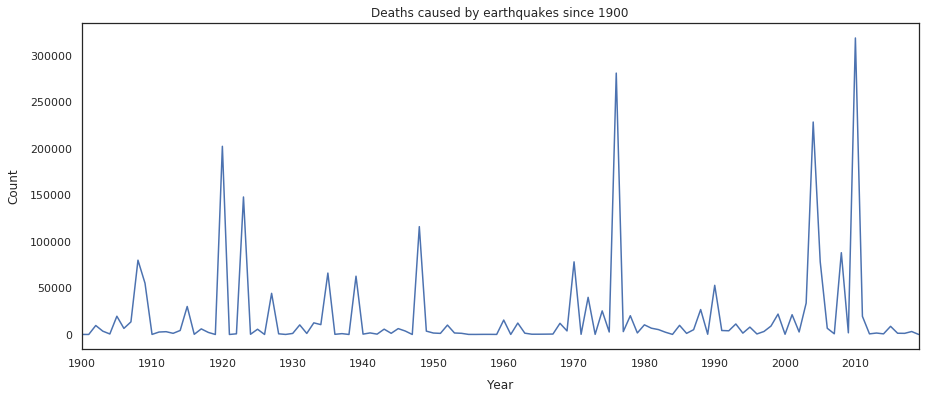

In [84]:
# Plot total deaths since 1900

eq_freq_year_deaths_1900 = earthquakes_since_1900.groupby('year')['total_deaths'].sum().sort_index()

ax = eq_freq_year_deaths_1900.plot(kind='line', figsize=(15, 6))
ax.set_xticks(np.arange(1900, 2019, 10))
ax.set_xticklabels(np.arange(1900, 2019, 10), rotation=0)
ax.set_title("Deaths caused by earthquakes since 1900")
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Count", labelpad=10)

plt.show()

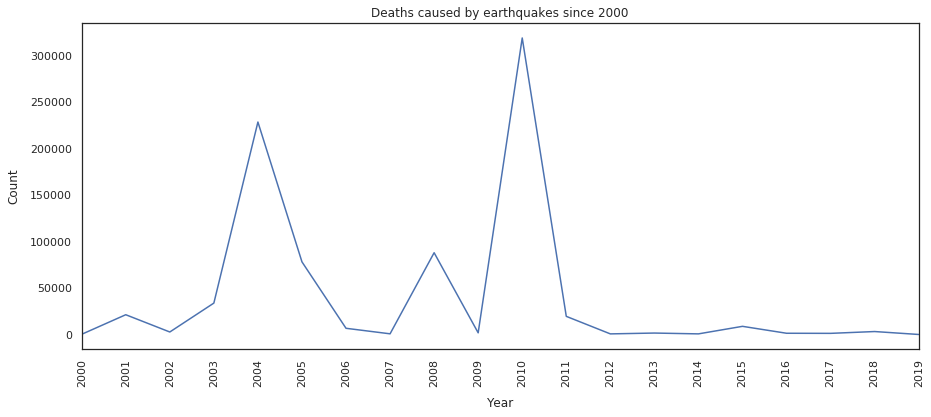

In [81]:
# Plot total deaths since 2000

eq_freq_year_deaths = earthquakes_since_2000.groupby('year')['total_deaths'].sum().sort_index()

ax = eq_freq_year_deaths.plot(kind='line', figsize=(15, 6))
ax.set_xticks(eq_freq_year_deaths.index)
ax.set_xticklabels(eq_freq_year_deaths.index, rotation=90)
ax.set_title("Deaths caused by earthquakes since 2000")
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Count", labelpad=10)

plt.show()

## Visualise earthquake frequency and mortality by year and region code

In [22]:
# Create dictionaries to map region codes to region description

region_codes = {10: 'Central, Western and S. Africa',
                15: 'Northern Africa',
                20: 'Antarctica',
                30: 'East Asia',
                40: 'Central Asia and Caucasus',
                50: 'Kamchatka and Kuril Islands',
                60: 'S. and SE. Asia and Indian Ocean',
                70: 'Atlantic Ocean',
                80: 'Bering Sea',
                90: 'Caribbean',
                100: 'Central America',
                110: 'Eastern Europe',
                120: 'Northern and Western Europe',
                130: 'Southern Europe',
                140: 'Middle East',
                150: 'North America and Hawaii',
                160: 'South America',
                170: 'Central and South Pacific'}

In [85]:
# Group earthquakes by year and region code and count number of earthquakes in each group

eq_year_region = earthquakes_since_2000.groupby(['year', 'region_code'])['id'].count().reset_index()
eq_year_region_deaths_2000 = earthquakes_since_2000.groupby(['year', 'region_code'])['total_deaths'].sum().reset_index()

In [86]:
# Create region column by mapping to region code

eq_year_region['region'] = eq_year_region['region_code'].map(region_codes) 
eq_year_region_deaths_2000['region'] = eq_year_region_deaths_2000['region_code'].map(region_codes)

In [25]:
eq_year_region.head()

,year,region_code,id,region
0,2000,10,2,"Central, Western and S. Africa"
1,2000,30,11,East Asia
2,2000,40,3,Central Asia and Caucasus
3,2000,50,1,Kamchatka and Kuril Islands
4,2000,60,5,S. and SE. Asia and Indian Ocean


In [88]:
# Pivot grouped data by creating a region per column with earthquake count as values and year as index

eq_year_region_piv = pd.pivot_table(eq_year_region,
                                    index='year', columns='region', values='id',
                                    aggfunc='sum').fillna(0)

eq_year_region_deaths_piv = pd.pivot_table(eq_year_region_deaths_2000,
                                    index='year', columns='region', values='total_deaths',
                                    aggfunc='sum').fillna(0)

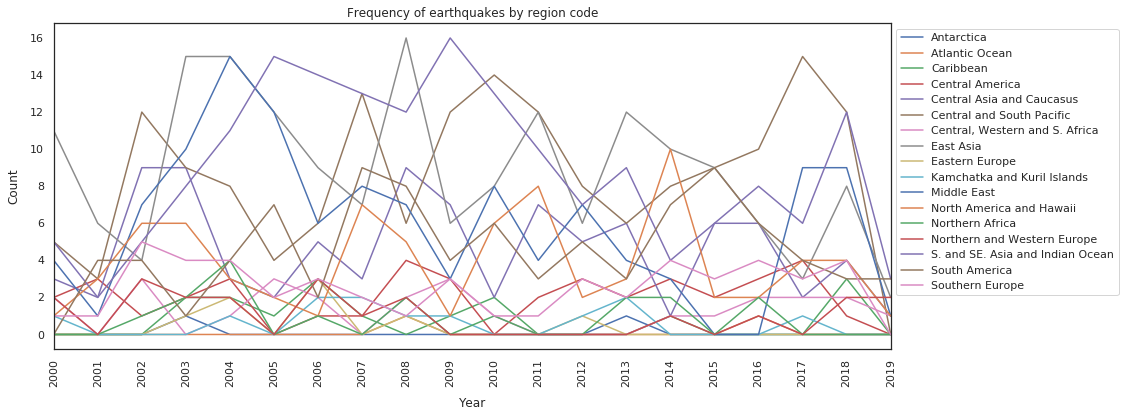

In [27]:
# Plot earthquake frequency per year by region 

ax = eq_year_region_piv.plot(kind='line', figsize=(15, 6))
ax.set_xticks(eq_year_region_piv.index)
ax.set_xticklabels(eq_year_region_piv.index, rotation=90)
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Count", labelpad=10)
ax.set_title("Frequency of earthquakes by region code")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

This looks very messy! Let's try grouping earthquake frequency by continent instead.

## Visualise earthquake frequency and mortality by year and continent

In [28]:
# Create dictionaries to map region description to continent

continent = {'Central, Western and S. Africa': 'Africa',
             'Northern Africa': 'Africa',
             'Antarctica': 'Antarctica', 
             'East Asia': 'Asia',
             'Central Asia and Caucasus': 'Asia',
             'Kamchatka and Kuril Islands': 'Asia',
             'S. and SE. Asia and Indian Ocean': 'Asia',
             'Atlantic Ocean': 'Atlantic Ocean',
             'Bering Sea': 'Pacific Ocean',
             'Caribbean': 'Central America',
             'Central America': 'Central America',
             'Eastern Europe': 'Europe',
             'Northern and Western Europe': 'Europe',
             'Southern Europe': 'Europe',
             'Middle East': 'Asia',
             'North America and Hawaii': 'North America',
             'South America': 'South America',
             'Central and South Pacific': 'Pacific Ocean'}

In [89]:
# Create continent column by mapping values using region column 

eq_year_region['continent'] = eq_year_region['region'].map(continent)
eq_year_region_deaths_2000['continent'] = eq_year_region_deaths_2000['region'].map(continent)

eq_year_region.head()

,year,region_code,id,region,continent
0,2000,10,2,"Central, Western and S. Africa",Africa
1,2000,30,11,East Asia,Asia
2,2000,40,3,Central Asia and Caucasus,Asia
3,2000,50,1,Kamchatka and Kuril Islands,Asia
4,2000,60,5,S. and SE. Asia and Indian Ocean,Asia


In [90]:
# Group by year and continent and sum up earthquake count

eq_year_continent = eq_year_region.groupby(['year', 'continent'])['id'].sum().reset_index()
eq_year_continent_deaths_2000 = eq_year_region_deaths_2000.groupby(['year', 'continent'])['total_deaths'].sum().reset_index()

eq_year_continent_deaths_2000.head()

,year,continent,total_deaths
0,2000,Africa,0.0
1,2000,Asia,169.0
2,2000,Central America,7.0
3,2000,Europe,0.0
4,2000,North America,0.0


In [92]:
# Pivot table so that columns are a continent, indexed by year with earthquake frequency as values

eq_year_continent_piv = pd.pivot_table(eq_year_continent,
                                       index='year', columns='continent', values='id',
                                       aggfunc='sum').fillna(0)

eq_year_continent_deaths_piv = pd.pivot_table(eq_year_continent_deaths_2000,
                                       index='year', columns='continent', values='total_deaths',
                                       aggfunc='sum').fillna(0)

eq_year_continent_deaths_piv

continent,Africa,Antarctica,Asia,Atlantic Ocean,Central America,Europe,North America,Pacific Ocean,South America
year,,,,,,,,,
2000,0.0,0.0,169.0,0.0,7.0,0.0,0.0,48.0,0.0
2001,0.0,0.0,20017.0,0.0,1160.0,0.0,1.0,0.0,108.0
2002,1005.0,0.0,1574.0,0.0,0.0,32.0,0.0,76.0,0.0
2003,2275.0,0.0,31505.0,0.0,5.0,0.0,31.0,2.0,0.0
2004,631.0,0.0,228080.0,0.0,9.0,1.0,0.0,70.0,1.0
2005,8.0,0.0,78180.0,0.0,0.0,0.0,0.0,1.0,16.0
2006,8.0,0.0,6663.0,0.0,1.0,0.0,0.0,4.0,0.0
2007,0.0,0.0,124.0,0.0,1.0,0.0,12.0,58.0,527.0
2008,41.0,0.0,88006.0,0.0,0.0,4.0,0.0,6.0,7.0


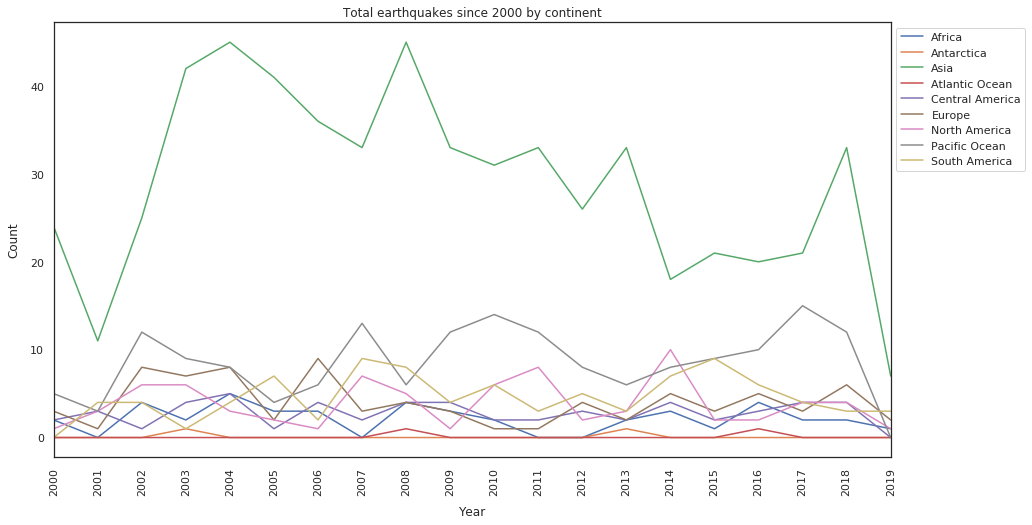

In [95]:
# Plot line graph of earthquake frequency per year by continent

ax = eq_year_continent_piv.plot(kind='line', figsize=(15, 8))
ax.set_xticks(eq_year_continent_piv.index)
ax.set_xticklabels(eq_year_continent_piv.index, rotation=90)
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Count", labelpad=10)
ax.set_title("Total earthquakes since 2000 by continent")
ax.legend(bbox_to_anchor=(1, 1))

plt.show()

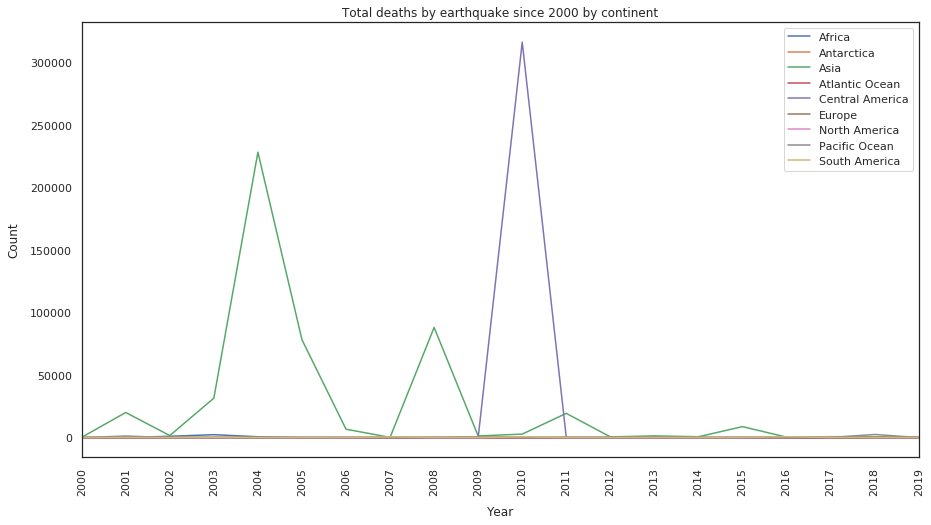

In [98]:
# Plot line graph of deaths caused by earthquakes per year by continent

ax = eq_year_continent_deaths_piv.plot(kind='line', figsize=(15, 8))
ax.set_xticks(eq_year_continent_deaths_piv.index)
ax.set_xticklabels(eq_year_continent_deaths_piv.index, rotation=90)
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Count", labelpad=10)
ax.set_title("Total deaths by earthquake since 2000 by continent")
ax.legend(bbox_to_anchor=(1, 1))

plt.show()

## Visualise deaths by earthquake intensity

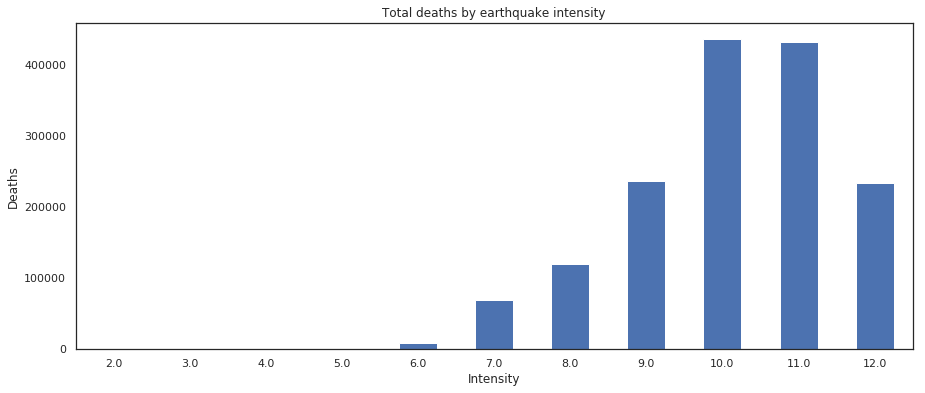

In [139]:
earthquakes_1900_intensity = earthquakes_since_1900.dropna(subset=['intensity'])

ax = earthquakes_1900_intensity.groupby('intensity')['total_deaths'].sum().plot(kind='bar', figsize=(15, 6))
ax.set_xticklabels(earthquakes_1900_intensity.groupby('intensity')['total_deaths'].sum().index, 
                  rotation=0)
ax.set_ylabel("Deaths")
ax.set_xlabel("Intensity")
ax.set_title("Total deaths by earthquake intensity")
plt.show()

## Visualise earthquakes by location

In [39]:
# Find frequency count of country in earthquakes since 1900 dataframe

earthquakes_since_1900['country'].value_counts().head(10)

CHINA          352
INDONESIA      280
JAPAN          238
IRAN           215
USA            186
TURKEY         164
ITALY          133
PHILIPPINES    120
RUSSIA         118
PERU           116
Name: country, dtype: int64

In [ ]:
# Plot top 10 countries with the most earthquakes since 1900

top_10_list = earthquakes_since_1900['country'].value_counts().index[:10].tolist()

ax = earthquakes_since_1900['country'].value_counts()[:10].plot.bar(figsize=(15, 6))
ax.set_xticklabels([word.title() if word != 'USA' else word.upper() for word in top_10_list],
                   rotation=0)
ax.set_xlabel("Country", labelpad=15)
ax.set_ylabel("Count")
ax.set_title("Top 10 countries with most earthquakes since 1900")

plt.show()

In [33]:
# Find frequency count of country in earthquakes since 2000 dataframe

earthquakes_since_2000['country'].value_counts().head(10)

CHINA          128
INDONESIA      113
IRAN            74
JAPAN           65
USA             50
INDIA           48
TURKEY          39
PHILIPPINES     29
PERU            28
CHILE           27
Name: country, dtype: int64

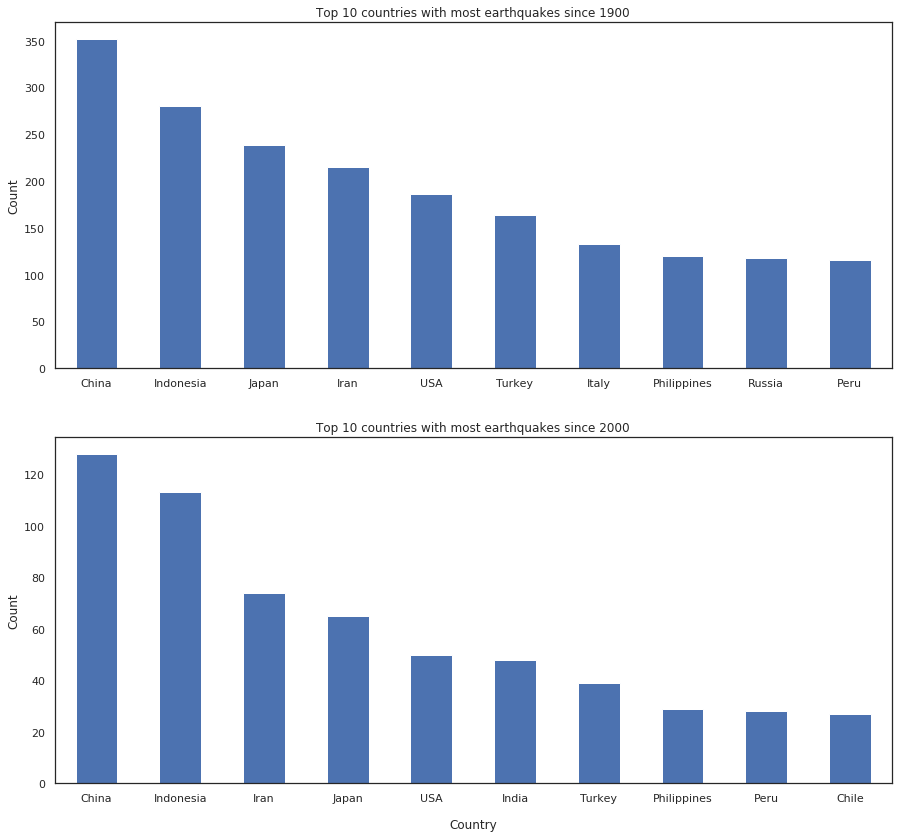

In [47]:
# Plot top 10 countries with the most earthquakes since 2000

top_10_list_1900 = earthquakes_since_1900['country'].value_counts().index[:10].tolist()
top_10_list_2000 = earthquakes_since_2000['country'].value_counts().index[:10].tolist()

fig = plt.figure(figsize=(15, 14))

ax1 = fig.add_subplot(2,1,2)
earthquakes_since_2000['country'].value_counts()[:10].plot.bar(ax=ax1)
ax1.set_xticklabels([word.title() if word != 'USA' else word.upper() for word in top_10_list_2000],
                   rotation=0)
ax1.set_xlabel("Country", labelpad=15)
#ax1.set_ylim(earthquakes_since_1900['country'].value_counts()[:10].min(), 
#             earthquakes_since_1900['country'].value_counts()[:10].max())
ax1.set_ylabel("Count")
ax1.set_title("Top 10 countries with most earthquakes since 2000")

ax2 = fig.add_subplot(2, 1, 1) 
earthquakes_since_1900['country'].value_counts()[:10].plot.bar(ax=ax2)
ax2.set_xticklabels([word.title() if word != 'USA' else word.upper() for word in top_10_list_1900],
                   rotation=0)
ax2.set_xlabel("")
ax2.set_ylabel("Count")
ax2.set_title("Top 10 countries with most earthquakes since 1900")

plt.show()

In [102]:
earthquakes_since_1900.groupby('country')['total_deaths'].sum().sort_values()

country
LAOS                                                 0.0
GERMANY                                              0.0
HUNGARY                                              0.0
ICELAND                                              0.0
INDIAN OCEAN                                         0.0
JORDAN                                               0.0
KERMADEC ISLANDS (NEW ZEALAND)                       0.0
KIRIBATI                                             0.0
LEBANON                                              0.0
MICRONESIA, FED. STATES OF                           0.0
NEW CALEDONIA                                        0.0
PACIFIC OCEAN                                        0.0
GABON                                                0.0
PALAU                                                0.0
SAUDI ARABIA                                         0.0
SLOVAKIA                                             0.0
SOLOMON SEA                                          0.0
SOUTH GEORGIA AND THE S

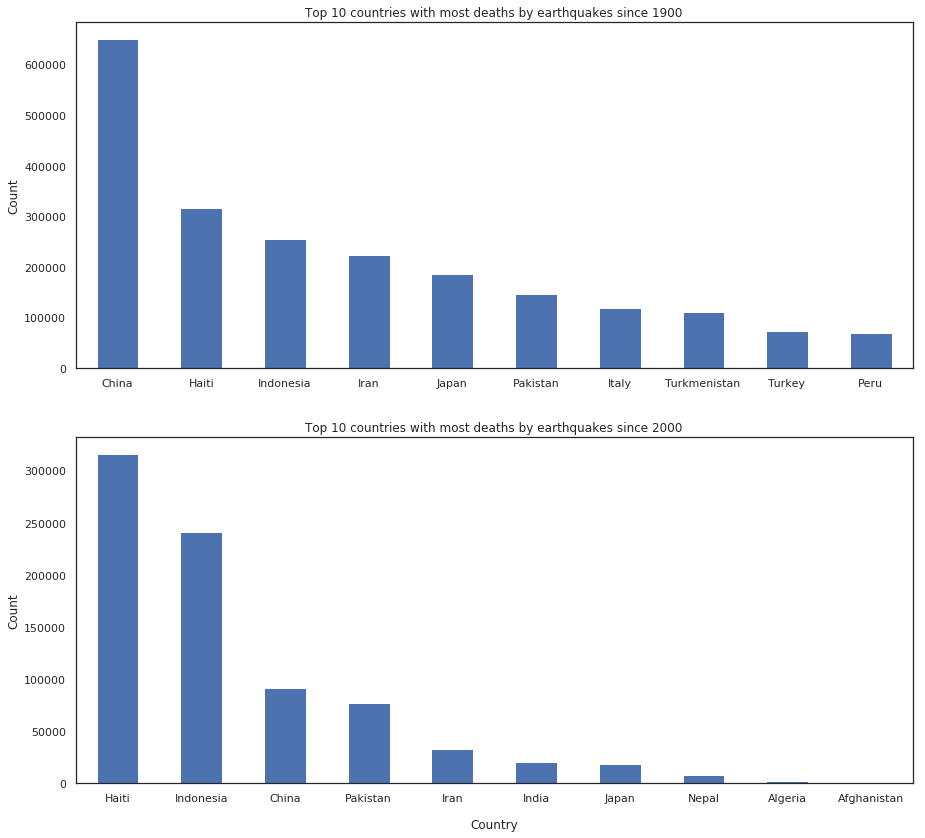

In [103]:
# Plot top 10 countries with the most earthquakes since 2000

top_10_deaths_list_1900 = earthquakes_since_1900.groupby('country')['total_deaths'].sum().sort_values(ascending=False).index[:10].tolist()
top_10_deaths_list_2000 = earthquakes_since_2000.groupby('country')['total_deaths'].sum().sort_values(ascending=False).index[:10].tolist()

fig = plt.figure(figsize=(15, 14))

ax1 = fig.add_subplot(2,1,2)
earthquakes_since_2000.groupby('country')['total_deaths'].sum().sort_values(ascending=False)[:10].plot.bar(ax=ax1)
ax1.set_xticklabels([word.title() if word != 'USA' else word.upper() for word in top_10_deaths_list_2000],
                   rotation=0)
ax1.set_xlabel("Country", labelpad=15)
#ax1.set_ylim(earthquakes_since_1900['country'].value_counts()[:10].min(), 
#             earthquakes_since_1900['country'].value_counts()[:10].max())
ax1.set_ylabel("Count")
ax1.set_title("Top 10 countries with most deaths by earthquakes since 2000")

ax2 = fig.add_subplot(2, 1, 1) 
earthquakes_since_1900.groupby('country')['total_deaths'].sum().sort_values(ascending=False)[:10].plot.bar(ax=ax2)
ax2.set_xticklabels([word.title() if word != 'USA' else word.upper() for word in top_10_deaths_list_1900],
                   rotation=0)
ax2.set_xlabel("")
ax2.set_ylabel("Count")
ax2.set_title("Top 10 countries with most deaths by earthquakes since 1900")

plt.show()

In [53]:
# Filter earthquake dataframe by top 2 countries

top_2 = earthquakes_since_1900['country'].value_counts()[:2].index.tolist()

top_2_eq = earthquakes_since_1900[earthquakes_since_1900['country'].isin(top_2)]

top_2_eq.head()

,country,latitude,longitude,year
290,CHINA,42.500,131.000,1917
291,CHINA,33.300,99.500,1947
292,CHINA,35.180,86.480,1973
293,CHINA,23.181,99.439,1988
294,CHINA,35.069,87.325,1997


In [54]:
# Count number of earthquakes in each top 10 country by year

top_2_year = top_2_eq.groupby(['year', 'country']).size().reset_index()

top_2_year_piv = pd.pivot_table(top_2_year, index='year', columns='country', values=0).fillna(0)

top_2_year_piv.columns = [word.title() for word in top_2_year_piv.columns] 

top_2_year_piv.head()

,China,Indonesia
year,,
1900,0.0,3.0
1901,1.0,0.0
1902,2.0,0.0
1903,0.0,2.0
1904,1.0,1.0


In [56]:
top_2_year_piv.index[0::10]

Int64Index([1900, 1910, 1921, 1931, 1941, 1952, 1962, 1972, 1983, 1993, 2003,
            2013],
           dtype='int64', name='year')

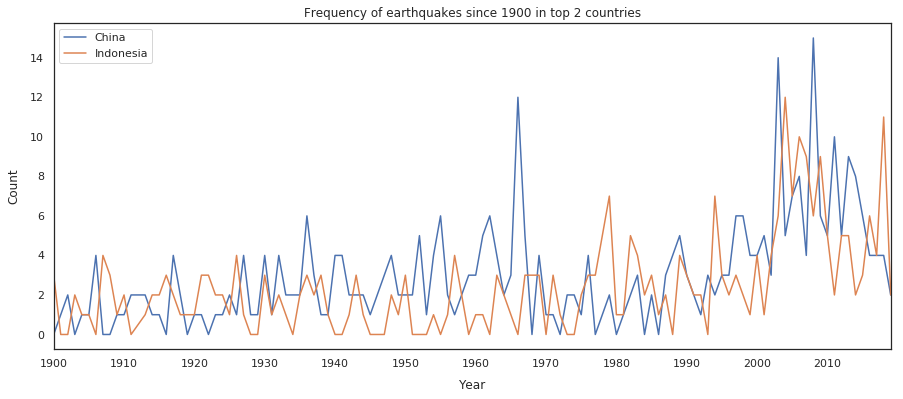

In [60]:
# Plot earthquake frequency per year in top 10 countries

ax = top_2_year_piv.plot(kind='line', figsize=(15, 6))
ax.set_xticks(np.arange(1900, 2019, 10))
ax.set_xticklabels(np.arange(1900, 2019, 10), rotation=0)
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Count", labelpad=10)
ax.set_title("Frequency of earthquakes since 1900 in top 2 countries")
ax.legend(loc='upper left')

plt.show()

## Visualise earthquake frequency with maps

In [61]:
import folium
from folium.plugins import HeatMap, HeatMapWithTime

In [70]:
def generateBaseMap(default_location=[40, 0], default_zoom_start=1.5):
    base_map = folium.Map(location=default_location, tiles='cartodbpositron', 
                          control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [117]:
# Generate heatmap of earthquake locations since 2000
earthquakes_2000 = generateBaseMap()

HeatMap(data=earthquakes_since_2000[['latitude', 'longitude']].values.tolist(),
        name="2000 to 2019",
        control=True,
        radius=10, max_zoom=13).add_to(earthquakes_2000)

earthquakes_2000

In [118]:
# Generate heatmap of earthquake death locations since 2000
earthquakes_2000_deaths = generateBaseMap()

HeatMap(data=list(zip(earthquakes_since_2000.latitude.values, 
                      earthquakes_since_2000.longitude.values, 
                      earthquakes_since_2000.total_deaths.fillna(0).values)),
        name="2000 to 2019",
        control=True,
        radius=10, max_zoom=13).add_to(earthquakes_2000_deaths)

earthquakes_2000_deaths

In [124]:
# Plot earthquake locations

earthquakes_1900 = generateBaseMap()

HeatMap(data=earthquakes_since_1900[['latitude', 'longitude']].dropna().values.tolist(),
        name="Frequency since 1900",
        radius=10, max_zoom=13).add_to(earthquakes_1900)

earthquakes_1900

In [125]:
# Plot earthquake deaths

dropmissing_death_1900 = earthquakes_since_1900.dropna(subset=['latitude', 'longitude']).fillna(0)

earthquakes_1900_deaths = generateBaseMap()

HeatMap(data=dropmissing_death_1900[['latitude', 'longitude', 'total_deaths']].values.tolist(),
        name="Deaths since 1900",
        radius=10, max_zoom=13).add_to(earthquakes_1900_deaths)

earthquakes_1900_deaths

In [126]:
# Add deaths layer to earthquakes_1900 map

HeatMap(data=dropmissing_death_1900[['latitude', 'longitude', 'total_deaths']].values.tolist(),
        name="Deaths since 1900",
        radius=10, max_zoom=13).add_to(earthquakes_1900)

folium.LayerControl().add_to(earthquakes_1900)

earthquakes_1900

## Animate earthquake locations over time

`folium` has a `HeatMapWithTime` class that allows for animation of heatmaps when the data is a list of a list of latitude-longitude coordinates grouped by a time dimension. 

The following heatmaps were saved as HTML files in case the animation does not work for certain web browsers.

In [73]:
# Let's look at earthquake locations over time

eq_year_list = []

for year in earthquakes_since_2000['year'].sort_values().unique():
    eq_year_df = earthquakes_since_2000.loc[earthquakes_since_2000['year'] == year, ['latitude', 'longitude']].values.tolist()
    eq_year_list.append(eq_year_df)

earthquakes_year = generateBaseMap()

HeatMapWithTime(eq_year_list,
                index=earthquakes_since_2000['year'].sort_values().unique().tolist(),
                radius=10,
                gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.8).add_to(earthquakes_year)

earthquakes_year.save("earthquakes_since_2000.html")

In [74]:
# Plot locations since 1900

eq_year_list = []

for year in earthquakes_since_1900['year'].sort_values().unique():
    eq_year_df = earthquakes_since_1900.loc[earthquakes_since_1900['year'] == year, ['latitude', 'longitude']].dropna().values.tolist()
    eq_year_list.append(eq_year_df)

earthquakes_year = generateBaseMap()

HeatMapWithTime(eq_year_list,
                index=earthquakes_since_1900['year'].sort_values().unique().tolist(),
                radius=10,
                gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.8).add_to(earthquakes_year)

earthquakes_year.save("earthquakes_since_1900.html")

In [129]:
# Plot locations since 1900

eq_year_list = []

for year in earthquakes_since_1900['year'].sort_values().unique():
    eq_year_df = earthquakes_since_1900.loc[earthquakes_since_1900['year'] == year, ['latitude', 'longitude', 'total_deaths']].dropna(subset=['latitude', 'longitude']).fillna(0).values.tolist()
    eq_year_list.append(eq_year_df)

earthquakes_deaths_year = generateBaseMap()

HeatMapWithTime(eq_year_list,
                index=earthquakes_since_1900['year'].sort_values().unique().tolist(),
                radius=10, 
                min_opacity=0.5, max_opacity=0.8).add_to(earthquakes_deaths_year)

earthquakes_deaths_year.save("earthquake_deaths_since_1900.html")

In [75]:
# Plot locations over decade

decades = np.arange(1900, 2019, 10)

eq_year_list = []

for year in decades:
    eq_year_df = earthquakes_since_1900.loc[(earthquakes_since_1900['year'] >= year) &
                                          (earthquakes_since_1900['year'] <= year + 9), ['latitude', 'longitude']].dropna().values.tolist()
    eq_year_list.append(eq_year_df)

earthquakes_year = generateBaseMap()

HeatMapWithTime(eq_year_list,
                radius=10,
                index=[str(i) + 's' for i in decades],
                gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.8).add_to(earthquakes_year)

earthquakes_year.save("earthquakes_by_decade.html")